## Dependencies

In [1]:
# Dependencies

import pandas as pd
import csv
import requests
from pprint import pprint
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sodapy import Socrata
import os
import gmaps
import numpy as np
from config import g_key

## Data collection and cleaning

In [2]:
# Data collection - year 2022 - post-covid

client = Socrata("data.melbourne.vic.gov.au", app_token="PJ7LNUcljkE0xkoj2J0AzMeU4", username="david_salim2006@hotmail.com", password="David!2022")
results_2022 = client.get("b2ak-trbp", year= 2022, limit = 10000000)
results_2022_df = pd.DataFrame.from_records(results_2022)
results_2022_df.to_csv("foottrafficsdata2022.csv")
results_2022_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,4279409,2022-05-02T12:00:00.000,2022,May,2,Monday,12,53,Collins St (North),1283
1,4279410,2022-05-02T13:00:00.000,2022,May,2,Monday,13,53,Collins St (North),1180
2,4279411,2022-05-02T14:00:00.000,2022,May,2,Monday,14,53,Collins St (North),1006
3,4279412,2022-05-02T15:00:00.000,2022,May,2,Monday,15,53,Collins St (North),837
4,4279413,2022-05-02T16:00:00.000,2022,May,2,Monday,16,53,Collins St (North),772


In [3]:
# Data 2022 cleaning - data types

results_2022_df.dtypes

id               object
date_time        object
year             object
month            object
mdate            object
day              object
time             object
sensor_id        object
sensor_name      object
hourly_counts    object
dtype: object

In [4]:
# Data 2022 cleaning - data types

data_type_dict = {"year":int,"time":int,"hourly_counts":float}
results_2022_df = results_2022_df.astype(data_type_dict).dropna()
results_2022_df.dtypes

id                object
date_time         object
year               int32
month             object
mdate             object
day               object
time               int32
sensor_id         object
sensor_name       object
hourly_counts    float64
dtype: object

In [5]:
# Data 2022 groupby

# results_2022_df= results_2022_df[(results_2022_df["time"] >= 12) & (results_2022_df["time"] <= 15)]
location = results_2022_df.groupby("sensor_name")
foottrafic_2022 = location["hourly_counts"].mean()
results_2022_groupby_df = pd.DataFrame({"Av foot traffic 2022": foottrafic_2022})
results_2022_groupby_df = results_2022_groupby_df.reset_index()
results_2022_groupby_df.rename(columns={"sensor_name":"location"},inplace=True)
results_2022_groupby_df = results_2022_groupby_df.replace({"Town Hall (West)":"Town Hall"})
results_2022_groupby_df.head()

,location,Av foot traffic 2022
0,231 Bourke St,342.918322
1,Alfred Place,97.101351
2,Birrarung Marr,179.197531
3,Bourke St - Spencer St (North),400.453918
4,Bourke St - Spencer St (South),88.625000


In [6]:
# Getting location coordinate

Location_list = results_2022_groupby_df["location"].tolist()

location = []
latitude = []
longitude = []

for i in Location_list:
    try:
        base_url = "https://maps.googleapis.com/maps/api/geocode/json"
        target_location2 = i + ", Melbourne Australia"
        params = {"address": target_location2, "key": g_key}
        response = requests.get(base_url, params=params)
        location_geo = response.json()
        lat = location_geo["results"][0]["geometry"]["location"]["lat"]
        lng = location_geo["results"][0]["geometry"]["location"]["lng"]
        print(f"{target_location2}: {lat}, {lng}")
        location.append(i)
        latitude.append(lat)
        longitude.append(lng)
    except:
        print("Target location not found")

231 Bourke St, Melbourne Australia: -37.8133992, 144.9668301
Alfred Place, Melbourne Australia: -37.8143404, 144.9701942
Birrarung Marr, Melbourne Australia: -37.8187351, 144.9742624
Bourke St - Spencer St (North), Melbourne Australia: -37.8170606, 144.9533436
Bourke St - Spencer St (South), Melbourne Australia: -37.8171069, 144.9531785
Bourke St Bridge, Melbourne Australia: -37.8159602, 144.9572025
Bourke St-Russell St (West), Melbourne Australia: -37.8128137, 144.968048
Bourke Street Mall (North), Melbourne Australia: -37.8137685, 144.9644379
Bourke Street Mall (South), Melbourne Australia: -37.8137685, 144.9644379
Chinatown-Lt Bourke St (South), Melbourne Australia: -37.812006, 144.9668036
Chinatown-Swanston St (North), Melbourne Australia: -37.8058235, 144.9631138
Collins Place (North), Melbourne Australia: -37.8144674, 144.9733256
Collins Place (South), Melbourne Australia: -37.8182937, 144.956676
Collins St (North), Melbourne Australia: -37.8182937, 144.956676
Elizabeth St - Flin

In [7]:
# create new df for location coordinate

location_dict = {"location": location, "Lat": latitude, "Lon": longitude}
location_data_dict = pd.DataFrame(location_dict)
location_data_dict.head()

,location,Lat,Lon
0,231 Bourke St,-37.813399,144.966830
1,Alfred Place,-37.814340,144.970194
2,Birrarung Marr,-37.818735,144.974262
3,Bourke St - Spencer St (North),-37.817061,144.953344
4,Bourke St - Spencer St (South),-37.817107,144.953179


In [8]:
# merging foot traffic data and coord data

data_summary_2022 = location_data_dict.merge(results_2022_groupby_df,how="left", on="location" )
data_summary_2022.to_csv ("datasummary2022.csv")
data_summary_2022.head(10)

sort_2022 = data_summary_2022.sort_values("Av foot traffic 2022", ascending=False).reset_index()
sort_2022.head()

,index,location,Lat,Lon,Av foot traffic 2022
0,19,Flinders La-Swanston St (West),-37.816485,144.966989,1312.665839
1,55,Southbank,-37.823840,144.962497,1182.980960
2,67,Town Hall,-37.815086,144.966565,1030.714931
3,45,Princes Bridge,-37.819240,144.968346,900.117550
4,39,Melbourne Central,-37.812365,144.962338,883.459161


In [9]:
# creating google heatmap

# location & foot traffic input
lat_long_all_location = sort_2022[["Lat", "Lon"]]
foottrafic_all_location = sort_2022["Av foot traffic 2022"]

# Plot Heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(lat_long_all_location, weights=foottrafic_all_location, max_intensity=1400)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Top Ten Location & Competition Analysis Incl. Heatmaps

In [10]:
# Top ten analysis

sort_2022 ["Accum. No of Competition"] = ""

top_10_2022 = sort_2022.iloc[0:10,:]
top_10_2022


,index,location,Lat,Lon,Av foot traffic 2022,Accum. No of Competition
0,19,Flinders La-Swanston St (West),-37.816485,144.966989,1312.665839,
1,55,Southbank,-37.823840,144.962497,1182.980960,
2,67,Town Hall,-37.815086,144.966565,1030.714931,
3,45,Princes Bridge,-37.819240,144.968346,900.117550,
4,39,Melbourne Central,-37.812365,144.962338,883.459161,
5,14,Elizabeth St - Flinders St (East) - New footpath,-37.818148,144.964871,815.621689,
6,61,State Library - New,-37.809809,144.965190,748.142660,
7,25,Flinders Street Station Underpass,-37.818271,144.967062,729.920530,
8,7,Bourke Street Mall (North),-37.813769,144.964438,719.423565,
9,41,Melbourne Convention Exhibition Centre,-37.825239,144.951917,697.614790,


In [11]:
# Top 10 location analysis / stats

desc = top_10_2022["Av foot traffic 2022"].describe()
desc

count      10.000000
mean      902.066167
std       210.914315
min       697.614790
25%       734.476062
50%       849.540425
75%       998.065585
max      1312.665839
Name: Av foot traffic 2022, dtype: float64

In [12]:
# creating google heatmap top ten

# location & foot traffic input
lat_long = top_10_2022[["Lat", "Lon"]]
foottrafic = top_10_2022["Av foot traffic 2022"]

# Plot Heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(lat_long, weights=foottrafic, max_intensity=1400)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
# All restaurant nearby

resto_name = []
resto_address = []
resto_lat = []
resto_lng = []

for index, row in top_10_2022.iterrows():
    phrase = f"restaurant in {row.location} Melbourne, Australia"
    target_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"

    params = {"query": phrase,"key": g_key, "radius": 100, "type": "restaurant"}

    response = requests.get(target_url, params)
    top_resto = response.json()
    for place in top_resto["results"]:
        print(place["name"])
        # print(place["formatted_address"])
        # print(place["geometry"]["location"]["lat"])
        # print(place["geometry"]["location"]["lng"])
        resto_name.append(place["name"])
        resto_address.append(place["formatted_address"])
        resto_lat.append(place["geometry"]["location"]["lat"])
        resto_lng.append(place["geometry"]["location"]["lng"])
        top_10_2022.loc[index, "Accum. No of Competition"] = len (resto_name)

Lollo
The Trust
Warabi
Lizzy
Saluministi Flinders Lane
Culprit
Tian38
Vapiano Flinders Lane
Go Hahn
Greta
Roule Galette
Yarra Falls
Akaiito Restaurant
Kim Sing Restaurant
Taxi Kitchen
Brunetti Oro Flinders Lane
Hazel
Shujinko Flinders
Cuff
Kenny's Bakery Cafe


c:\Users\david\Anaconda3\envs\bootcamp\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


The Deck Southbank
La Camera Southgate
The Meat & Wine Co Southbank
Left Bank Melbourne Restaurant & Cocktail Bar
The Atlantic
Asado
The Breslin Bar & Grill
Soho Restaurant and Bar
Miyako Japanese Cuisine & Teppanyaki
Spice Temple
Saporito Taquito
Bistro Guillaume
Rosetta Ristorante
Eureka 89 Dining & Events - Fine Dining Restaurant Melbourne
Teatro Restaurant
Dee Casa - Restaurant & Bar
Rockpool Bar & Grill
Tutto Bene
Nobu
Gradi at Crown
Osteria Ilaria
Hazel
The Waiters Restaurant
Locanda Restaurant & Public Bar
Tipo 00
Trattoria Emilia
Rice Paper Scissors
Food hall
Pretty Boy Italian Steakhouse
Angliss Restaurant
Palermo Restaurant
The Mill Restaurant - Melbourne CBD Restaurant & Bar
Choo Choo's
Rare Steakhouse Uptown
Vons Restaurant & Bar
Punch Lane Wine Bar & Restaurant
Sezar Restaurant
Meatmaiden
Makan
Flower Drum Restaurant Melbourne
Riverland Bar
Taxi Kitchen
Hazel
Spirit Of Melbourne Cruising Restaurant
Pilgrim Bar
Mama's Canteen
Eureka 89 Dining & Events - Fine Dining Restaura

In [14]:
# Show accum. number of competition radius 100m of top 10 location

top_10_2022

,index,location,Lat,Lon,Av foot traffic 2022,Accum. No of Competition
0,19,Flinders La-Swanston St (West),-37.816485,144.966989,1312.665839,20
1,55,Southbank,-37.823840,144.962497,1182.980960,40
2,67,Town Hall,-37.815086,144.966565,1030.714931,60
3,45,Princes Bridge,-37.819240,144.968346,900.117550,80
4,39,Melbourne Central,-37.812365,144.962338,883.459161,100
5,14,Elizabeth St - Flinders St (East) - New footpath,-37.818148,144.964871,815.621689,120
6,61,State Library - New,-37.809809,144.965190,748.142660,140
7,25,Flinders Street Station Underpass,-37.818271,144.967062,729.920530,160
8,7,Bourke Street Mall (North),-37.813769,144.964438,719.423565,180
9,41,Melbourne Convention Exhibition Centre,-37.825239,144.951917,697.614790,200


In [15]:
# Creating resto dataframe for heatmap marker

resto_dict = {"name": resto_name, "address": resto_address, "Lat": resto_lat, "Lon": resto_lng}
resto_df = pd.DataFrame(resto_dict)
resto_df.head()

,name,address,Lat,Lon
0,Lollo,"408 Flinders Ln, Melbourne VIC 3000, Australia",-37.818276,144.960305
1,The Trust,"405 Flinders Ln, Melbourne VIC 3000, Australia",-37.818444,144.960517
2,Warabi,"408 Flinders Ln, Melbourne VIC 3000, Australia",-37.818276,144.960305
3,Lizzy,"Flinders St, Melbourne VIC 3000, Australia",-37.819028,144.961508
4,Saluministi Flinders Lane,"388 Flinders Ln, Melbourne VIC 3000, Australia",-37.818121,144.961072


In [16]:
# add restaurant markers to the heatmap top ten

info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Address</dt><dd>{address}</dd>
</dl>
"""

resto_info = [info_box_template.format(**row) for index, row in resto_df.iterrows()]
locations = resto_df[["Lat", "Lon"]]

# Add marker layer ontop of heat map

marker_layer=gmaps.marker_layer(locations, info_box_content=resto_info)
fig.add_layer(marker_layer)

# Display figure

fig


Figure(layout=FigureLayout(height='420px'))

## Correlation Analysis - daily average foot traffic vs. daily temperature 2019

In [17]:
# Daily temperature data 2019

weather_data = pd.read_csv("IDCJAC0010_086338_2019_Data.csv")
weather_df= pd.DataFrame(weather_data)
weather_df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86338,2019,1,1,26.2,1,Y
1,IDCJAC0010,86338,2019,1,2,22.2,1,Y
2,IDCJAC0010,86338,2019,1,3,29.5,1,Y
3,IDCJAC0010,86338,2019,1,4,42.6,1,Y
4,IDCJAC0010,86338,2019,1,5,21.2,1,Y


In [18]:
# Daily temperature data 2019 adjustment / cleaning

weather_df ["Month"] = weather_df ["Month"].replace({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

weather_df


,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86338,2019,January,1,26.2,1,Y
1,IDCJAC0010,86338,2019,January,2,22.2,1,Y
2,IDCJAC0010,86338,2019,January,3,29.5,1,Y
3,IDCJAC0010,86338,2019,January,4,42.6,1,Y
4,IDCJAC0010,86338,2019,January,5,21.2,1,Y
...,...,...,...,...,...,...,...,...
360,IDCJAC0010,86338,2019,December,27,23.9,1,Y
361,IDCJAC0010,86338,2019,December,28,28.4,1,Y
362,IDCJAC0010,86338,2019,December,29,33.2,1,Y
363,IDCJAC0010,86338,2019,December,30,40.8,1,Y


In [19]:
weather_df ["month+day"] = weather_df ["Month"].map(str) + weather_df ["Day"].map(str)
weather_df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality,month+day
0,IDCJAC0010,86338,2019,January,1,26.2,1,Y,January1
1,IDCJAC0010,86338,2019,January,2,22.2,1,Y,January2
2,IDCJAC0010,86338,2019,January,3,29.5,1,Y,January3
3,IDCJAC0010,86338,2019,January,4,42.6,1,Y,January4
4,IDCJAC0010,86338,2019,January,5,21.2,1,Y,January5


In [20]:
# Foot traffic data 2019

client = Socrata("data.melbourne.vic.gov.au", app_token="PJ7LNUcljkE0xkoj2J0AzMeU4", username="david_salim2006@hotmail.com", password="David!2022")

results_2019 = client.get("b2ak-trbp", year= 2019, limit = 10000000)

results_2019_df = pd.DataFrame.from_records(results_2019)
results_2019_df.to_csv("foottrafficsdata2019.csv")

results_2019_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774


In [21]:
# Foot traffic data 2019 adjustment / cleaning
data_type_dict2 = {"hourly_counts":float}
results_2019_df = results_2019_df.astype(data_type_dict2)
results_2019_df.dtypes

id                object
date_time         object
year              object
month             object
mdate             object
day               object
time              object
sensor_id         object
sensor_name       object
hourly_counts    float64
dtype: object

In [22]:
results_2019_df ["month+day"] = results_2019_df ["month"] + results_2019_df ["mdate"]
results_2019_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,month+day
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300.0,November1
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604.0,November1
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216.0,November1
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627.0,November1
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774.0,November1


In [23]:
# Foot traffic data 2019 calculation

location_2019 = results_2019_df.groupby("month+day")
daily_foottrafic_2019 = location_2019["hourly_counts"].mean()

results_2019_groupby_df = pd.DataFrame({"av foot traffic 2019": daily_foottrafic_2019})
results_2019_groupby_df = results_2019_groupby_df.reset_index().dropna()
results_2019_groupby_df.head()


,month+day,av foot traffic 2019
0,April1,610.847500
1,April10,714.683333
2,April11,729.284167
3,April12,817.252500
4,April13,626.582500


In [24]:
# Data Merging
weather_foottrafic_2019 = results_2019_groupby_df.merge(weather_df, how="left", on="month+day")
weather_foottrafic_2019.head()

,month+day,av foot traffic 2019,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,April1,610.847500,IDCJAC0010,86338,2019,April,1,17.1,1,Y
1,April10,714.683333,IDCJAC0010,86338,2019,April,10,15.8,1,Y
2,April11,729.284167,IDCJAC0010,86338,2019,April,11,17.3,1,Y
3,April12,817.252500,IDCJAC0010,86338,2019,April,12,24.9,1,Y
4,April13,626.582500,IDCJAC0010,86338,2019,April,13,20.7,1,Y


The r-value is: 0.012467008841536353


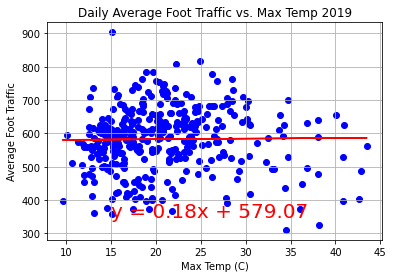

In [25]:
# Scatter plot & regression

x = weather_foottrafic_2019["Maximum temperature (Degree C)"]
y = weather_foottrafic_2019["av foot traffic 2019"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter (x,y, marker="o", facecolors="blue", alpha=1)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (15,350),fontsize=20,color="red")
plt.xlabel("Max Temp (C)")
plt.ylabel("Average Foot Traffic")
plt.title("Daily Average Foot Traffic vs. Max Temp 2019")
print(f"The r-value is: {rvalue}")
plt.grid()
plt.savefig("Fig1.png") 
plt.show()

- There is no relationship / very weak relatiobship between foot traffic vs. weather, r-values are close to 0.
- Melbournians go to Melbourne CBD regardless of weather

## Correlation Analysis - daily average foot traffic vs. daily temperature 2022

In [26]:
# Daily temperature data 2022

weather_data2 = pd.read_csv("IDCJAC0010_086338_2022_Data.csv")
weather_df2= pd.DataFrame(weather_data2)
weather_df2.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86338,2022,1,1,37.1,1,Y
1,IDCJAC0010,86338,2022,1,2,30.9,1,Y
2,IDCJAC0010,86338,2022,1,3,20.3,1,Y
3,IDCJAC0010,86338,2022,1,4,23.1,1,Y
4,IDCJAC0010,86338,2022,1,5,29.3,1,Y


In [27]:
# Daily temperature data 2022 adjustment / cleaning

weather_df2 ["Month"] = weather_df2 ["Month"].replace({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

weather_df2.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,86338,2022,January,1,37.1,1,Y
1,IDCJAC0010,86338,2022,January,2,30.9,1,Y
2,IDCJAC0010,86338,2022,January,3,20.3,1,Y
3,IDCJAC0010,86338,2022,January,4,23.1,1,Y
4,IDCJAC0010,86338,2022,January,5,29.3,1,Y


In [28]:
weather_df2 ["month+day"] = weather_df2 ["Month"].map(str) + weather_df2 ["Day"].map(str)
weather_df2.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality,month+day
0,IDCJAC0010,86338,2022,January,1,37.1,1,Y,January1
1,IDCJAC0010,86338,2022,January,2,30.9,1,Y,January2
2,IDCJAC0010,86338,2022,January,3,20.3,1,Y,January3
3,IDCJAC0010,86338,2022,January,4,23.1,1,Y,January4
4,IDCJAC0010,86338,2022,January,5,29.3,1,Y,January5


In [29]:
# Foot traffic data 2022

results_2022_df.head()


,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,4279409,2022-05-02T12:00:00.000,2022,May,2,Monday,12,53,Collins St (North),1283.0
1,4279410,2022-05-02T13:00:00.000,2022,May,2,Monday,13,53,Collins St (North),1180.0
2,4279411,2022-05-02T14:00:00.000,2022,May,2,Monday,14,53,Collins St (North),1006.0
3,4279412,2022-05-02T15:00:00.000,2022,May,2,Monday,15,53,Collins St (North),837.0
4,4279413,2022-05-02T16:00:00.000,2022,May,2,Monday,16,53,Collins St (North),772.0


In [30]:
results_2022_df ["month+day"] = results_2022_df ["month"] + results_2022_df ["mdate"]
results_2022_df.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,month+day
0,4279409,2022-05-02T12:00:00.000,2022,May,2,Monday,12,53,Collins St (North),1283.0,May2
1,4279410,2022-05-02T13:00:00.000,2022,May,2,Monday,13,53,Collins St (North),1180.0,May2
2,4279411,2022-05-02T14:00:00.000,2022,May,2,Monday,14,53,Collins St (North),1006.0,May2
3,4279412,2022-05-02T15:00:00.000,2022,May,2,Monday,15,53,Collins St (North),837.0,May2
4,4279413,2022-05-02T16:00:00.000,2022,May,2,Monday,16,53,Collins St (North),772.0,May2


In [31]:
# Foot traffic data 2022 calculation

location_2022 = results_2022_df.groupby("month+day")
daily_foottrafic_2022 = location_2022["hourly_counts"].mean()

results_2022_groupby_df = pd.DataFrame({"av foot traffic 2022": daily_foottrafic_2022})
results_2022_groupby_df = results_2022_groupby_df.reset_index().dropna()
results_2022_groupby_df.head()


,month+day,av foot traffic 2022
0,April1,418.676136
1,April10,467.524621
2,April11,394.501894
3,April12,427.364899
4,April13,432.839015


In [32]:
# Data Merging
weather_foottrafic_2022 = results_2022_groupby_df.merge(weather_df2, how="left", on="month+day")
weather_foottrafic_2022.head()


,month+day,av foot traffic 2022,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,April1,418.676136,IDCJAC0010,86338,2022,April,1,19.1,1,Y
1,April10,467.524621,IDCJAC0010,86338,2022,April,10,26.7,1,Y
2,April11,394.501894,IDCJAC0010,86338,2022,April,11,18.8,1,Y
3,April12,427.364899,IDCJAC0010,86338,2022,April,12,17.7,1,Y
4,April13,432.839015,IDCJAC0010,86338,2022,April,13,20.0,1,Y


The r-value is: -0.3129560741673479


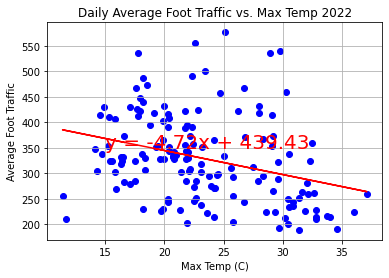

In [33]:
# Scatter plot & regression

x2 = weather_foottrafic_2022["Maximum temperature (Degree C)"]
y2 = weather_foottrafic_2022["av foot traffic 2022"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x2, y2)
regress_values = x2 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter (x2,y2, marker="o", facecolors="blue", alpha=1)
plt.plot(x2,regress_values,"r-")
plt.annotate(line_eq, (15,350),fontsize=20,color="red")
plt.xlabel("Max Temp (C)")
plt.ylabel("Average Foot Traffic")
plt.title("Daily Average Foot Traffic vs. Max Temp 2022")
print(f"The r-value is: {rvalue}")
plt.grid()
plt.savefig("Fig1.png") 
plt.show()

## Correlation Analysis - daily average foot traffic 2019 vs. day of the year 2019

In [34]:
# foot traffic data 2019

results_2019_df_2 = results_2019_df.copy()
results_2019_df_2['Date'] = pd.to_datetime(results_2019_df_2["date_time"]).dt.date
results_2019_df_2.head()

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,month+day,Date
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300.0,November1,2019-11-01
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604.0,November1,2019-11-01
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216.0,November1,2019-11-01
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627.0,November1,2019-11-01
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774.0,November1,2019-11-01


In [35]:
# foot traffic data 2019 calculation
groupby_date = results_2019_df_2.groupby("Date")

daily_foottraffic_by_date = groupby_date["hourly_counts"].mean()

results_2019_foottraffic_bydate = pd.DataFrame({"Av foot traffic 2019": daily_foottraffic_by_date})
results_2019_foottraffic_bydate = results_2019_foottraffic_bydate.reset_index().dropna()
results_2019_foottraffic_bydate.head()

,Date,Av foot traffic 2019
0,2019-01-01,469.195578
1,2019-01-02,522.727891
2,2019-01-03,517.563776
3,2019-01-04,403.606293
4,2019-01-05,454.995833


The r-value is: 0.14195185271907143


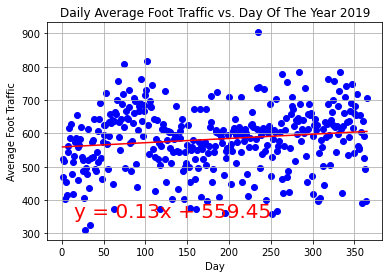

In [36]:
# Scatter plot & regression 

x = np.arange(1,366,1)
y = results_2019_foottraffic_bydate["Av foot traffic 2019"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter (x,y, marker="o", facecolors="blue", alpha=1)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (15,350),fontsize=20,color="red")
plt.xlabel("Day")
plt.ylabel("Average Foot Traffic")
plt.title("Daily Average Foot Traffic vs. Day Of The Year 2019")
print(f"The r-value is: {rvalue}")
plt.grid()
plt.savefig("Fig2.png") 
plt.show()



- There is a very weak relationship between foot traffic vs. day / season of the year, r-value is close to 0.
- Slight increase in foot traffic towards end of the year